## Import required libraries

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree
import json
# graph representation
import networkx as nx
# GNU linear programming kit (to use GLPK)
import pulp
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, ConstantWaveform, InterpolatedWaveform
from pulser_simulation import SimConfig, QutipEmulator

## Define Problem Data

### retrieved popuplation

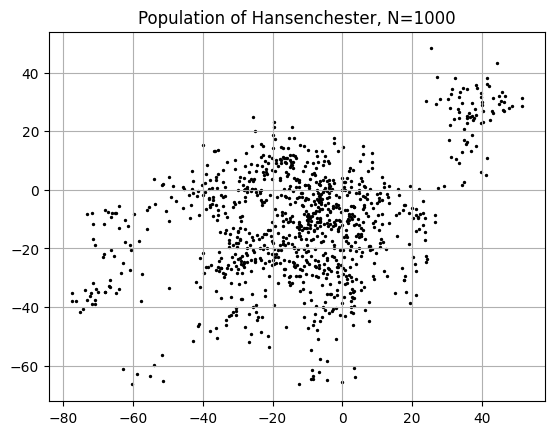

In [284]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)

### Coverage function to maximize

Optimization Function $COV$ for $N$ antennas is given by:

$$
COV = \sum_{i \in N} d_R(i) - B \sum_{i,j \in A} \text{Interfere}(i, j)
$$

where:

$$
\text{Interfere}(i, j) = \begin{cases} 
1, & \text{if } ||\vec{r}_i - \vec{r}_j|| < 2R \\
0, & \text{otherwise}
\end{cases}
$$

with
- coverage radius $R$ = 25
- antenna position $\vec{r}_i$
- $d_R(i)$ the nb. of population points within radius R around $\vec{r}_i$
- interference for $d < 2R$
- maximum nb. of antennas = 70
- minimum coverage = 0.7 $\times$ #population


In [285]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost

### Generate the grid

In [286]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

### Define the problem parameters

In [287]:
# Problem Parameters
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required
# Grid Parameters
spacing = 2*R_antennas  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points


Calculate the coverage at each point of the grid

In [288]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[population_x[i], population_y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

Plot the coverage map

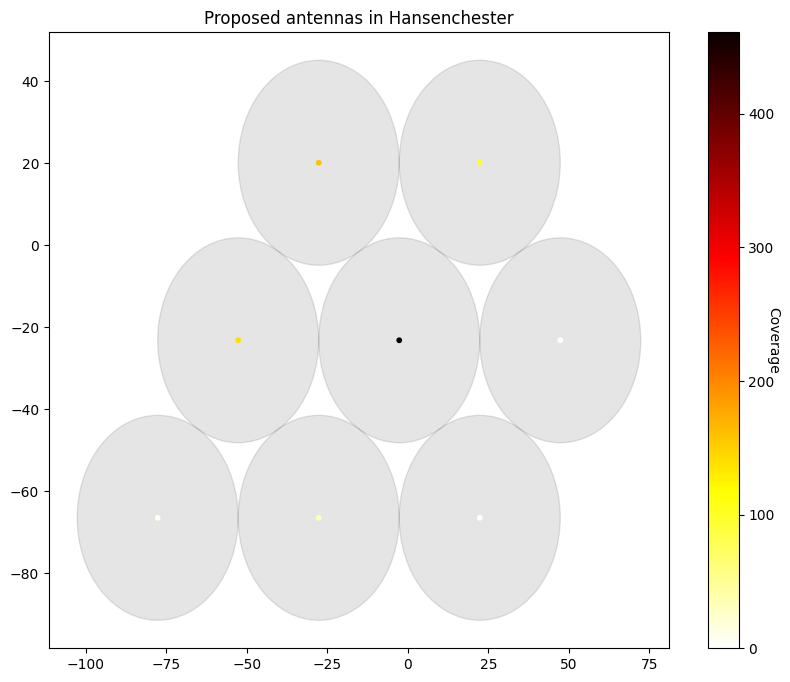

In [289]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if z_coverage[ind] > 1e-3:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

{0: Text(-77.68360424927863, -66.44904946050465, '0'),
 1: Text(-27.68360424927863, -66.44904946050465, '1'),
 2: Text(22.31639575072137, -66.44904946050465, '2'),
 4: Text(-2.6836042492786305, -23.147779271282722, '4'),
 3: Text(-52.68360424927863, -23.147779271282722, '3'),
 5: Text(47.31639575072137, -23.147779271282722, '5'),
 8: Text(22.31639575072137, 20.15349091793921, '8'),
 7: Text(-27.68360424927863, 20.15349091793921, '7'),
 6: Text(-77.68360424927863, 20.15349091793921, '6')}

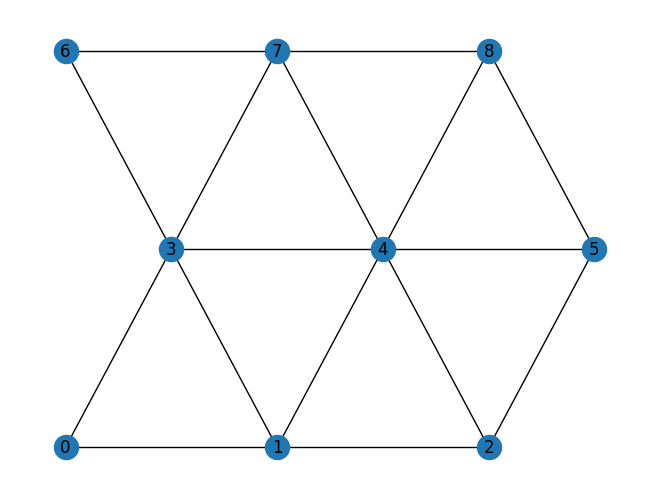

In [290]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

# Pulser Implementation

In [291]:
device_used = MockDevice
seed = 100

In [292]:
omega_max = (2.5*R_antennas/10)**(-6) * device_used.interaction_coeff
#omega_max = 30
delta_0 = -3*omega_max
delta_f = -delta_0
print(f'Omega max: {omega_max}')
print(f'Delta max: {delta_0}')
print(f'Rydberg blockade radius: {device_used.rydberg_blockade_radius(omega_max)}')

Omega max: 90.93517041205249
Delta max: -272.8055112361575
Rydberg blockade radius: 6.249999999999999


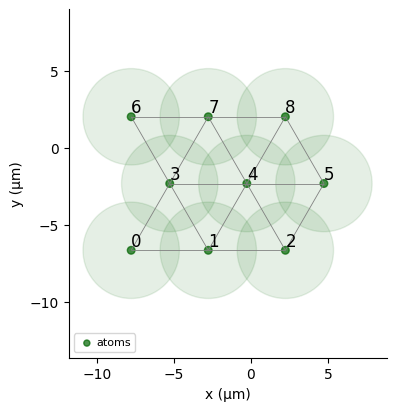

In [293]:
# create a register on NAQC
qubits = dict(enumerate(np.array(grid_points)/10))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

In [294]:
t_rise = 800 # ns
t_sweep = 2000
t_fall = 800

In [295]:
# set pulse
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0,
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0,
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0,
)

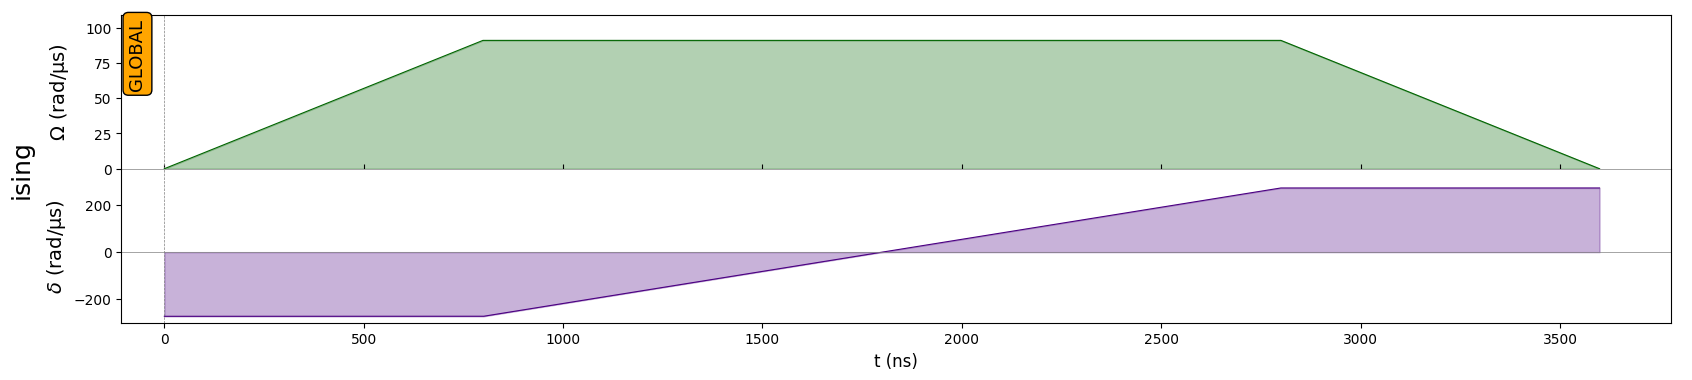

In [296]:
# draw the pulse
seq = Sequence(reg, device=device_used)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

In [297]:
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [298]:
simulator = QutipEmulator.from_sequence(
    seq, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=1000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   1.09s. Est. time left: 00:00:00:09
20.0%. Run time:   2.26s. Est. time left: 00:00:00:09
30.0%. Run time:   2.66s. Est. time left: 00:00:00:06
40.0%. Run time:   3.02s. Est. time left: 00:00:00:04
50.0%. Run time:   3.45s. Est. time left: 00:00:00:03
60.0%. Run time:   3.90s. Est. time left: 00:00:00:02
70.0%. Run time:   4.46s. Est. time left: 00:00:00:01
80.0%. Run time:   5.02s. Est. time left: 00:00:00:01
90.0%. Run time:   5.55s. Est. time left: 00:00:00:00
Total run time:   6.11s


In [299]:
most_frequent = {k:v for k,v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

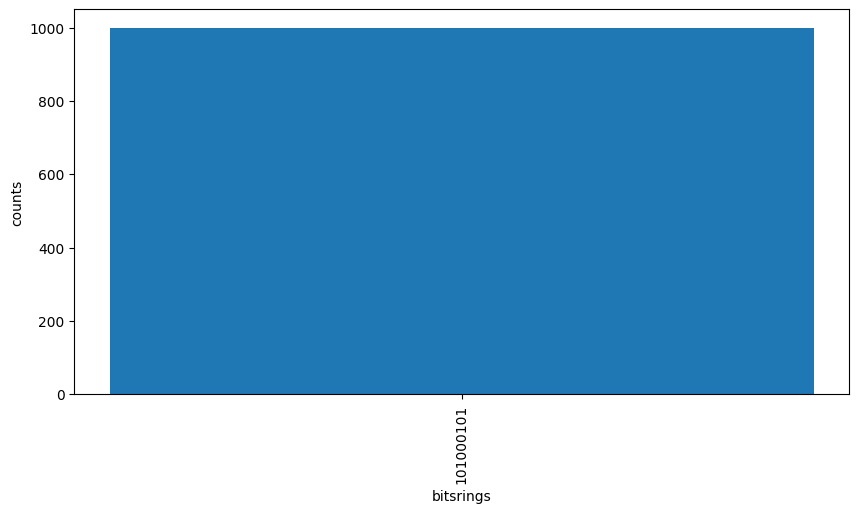

In [300]:
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

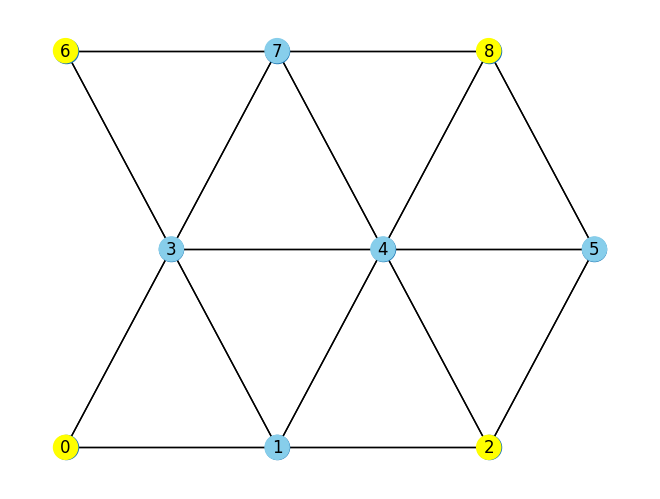

In [301]:
# Sort the bitstrings in descending order
solution = sorted(most_frequent, reverse=True)

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Convert the bitstrings to lists of node indices and select the top 5
solution_indices = [convert_to_indices(res) for res in solution]
top_5 = solution_indices[:5]

# Calculate the total weight (sum of node indices) for each set in the top 5
val_list = [sum(node_set) for node_set in top_5]

# Find the index of the set with the maximum total weight
ind_max = np.argmax(val_list)

# Draw the graph with colored nodes
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

color = []
for i in solution[0]:
    if i == "1":
        color.append('yellow')
    else:
        color.append('skyblue')

nx.draw(graph, pos=grid_points, node_color=color)